In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from matplotlib.collections import LineCollection
import os
import pickle as pkl
from LRBv2 import LRBv2
from LRBv21 import LRBv21
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()



# IO

In [2]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()

sepadd = 2
eqb = dict()

for side in ["iu", "ou"]:
    eqb[side] = dict()
    
    for design in designs:    
        eqb[side][design] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=sepadd, resolution = 1000)

In [4]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()

sepadd = 2
eqblog = dict()

for side in ["iu", "ou"]:
    eqblog[side] = dict()
    
    for design in designs:    
        eqblog[side][design] = unpackConfigurationMK(File = file_paths[design], 
                                                     log_grid = True, Type = side, sepadd=sepadd, resolution = 100000)

In [5]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()

sepadd = 2
eqblog1k = dict()

for side in ["iu", "ou"]:
    eqblog1k[side] = dict()
    
    for design in designs:    
        eqblog1k[side][design] = unpackConfigurationMK(File = file_paths[design], 
                                                     log_grid = True, Type = side, sepadd=sepadd, resolution = 1000)

In [6]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()

sepadd = 2
eqb100k = dict()

for side in ["iu", "ou"]:
    eqb100k[side] = dict()
    
    for design in designs:    
        eqb100k[side][design] = unpackConfigurationMK(File = file_paths[design], 
                                                     log_grid = True, Type = side, sepadd=sepadd, resolution = 100000)

In [7]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()

sepadd = 2
eqb20k = dict()

for side in ["iu", "ou"]:
    eqb20k[side] = dict()
    
    for design in designs:    
        eqb20k[side][design] = unpackConfigurationMK(File = file_paths[design], 
                                                     log_grid = True, Type = side, sepadd=sepadd, resolution = 20000)

In [8]:
#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.05,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


In [7]:
design = "SPR38"
list_q = [0.25e9, 0.50e9, 1.0e9]
list_cvars = ["impurity_frac", "density", "power"]
mvar = dict()

for side in ["iu","ou"]:
    mvar[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        mvar[side][cvar] = dict()
        print(f"{cvar}")
        
        for q0 in list_q:
            print("q value {}...".format(q0))

            d = eqb[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05

            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            constants["qpllu0"] = q0

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)

            mvar[side][cvar][q0] = out

Side iu...
impurity_frac
q value 250000000.0...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 33.3 seconds
q value 500000000.0...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 28.2 seconds
q value 1000000000.0...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 32.5 seconds
density
q value 250000000.0...
Solving...0...19...35...49...60...70...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


77...84...89...92...95...98...100...102...104...Complete in 37.8 seconds
q value 500000000.0...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 33.1 seconds
q value 1000000000.0...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 40.2 seconds
power
q value 250000000.0...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...

C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


100...102...104...Complete in 58.8 seconds
q value 500000000.0...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 42.9 seconds
q value 1000000000.0...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 54.1 seconds
Side ou...
impurity_frac
q value 250000000.0...
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 28.9 seconds
q value 500000000.0...
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 28.4 seconds
q value 1000000000.0...
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 37.2 seconds
density
q value 250000000.0...
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 42.8 seconds
q value 500000000.0...
Solving...0...56...98...133...166...198...229...258..

In [35]:
qscan[side][cvar][q0] = out

dict_keys([250000000.0, 500000000.0, 1000000000.0])

NameError: name 'mvar' is not defined

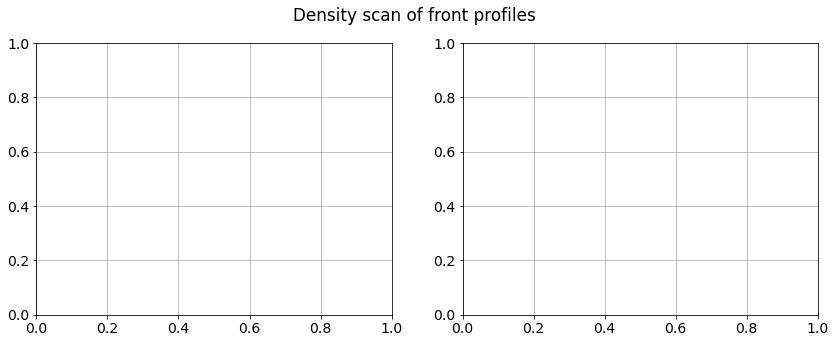

In [87]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(3)

C_dict = {"density":1, "impurity_frac":0.5, "power":-5/7}
labels_dict = {"density":"$n_{u}$", "impurity_frac":"$\sqrt{f_{z}}$", "power":"$q_{\parallel}^{-5/7}$"}

fig, axes = plt.subplots(1,2, figsize = (14,5))
fig.suptitle("Density scan of front profiles")
ax = axes[0]
list_q = [0.25e9]
basis = "crel"

for k, side in enumerate(["ou", "iu"]):

    for i, cvar in enumerate(list_cvars):
        o = mvar[side][cvar][q0].copy()

        x = o[basis] ** C_dict[cvar]

        
        if cvar == "density":
            axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 6, linewidth = 3, linestyle="dotted", color = colors[i], label = labels_dict[cvar])
        else:
            axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 6, linewidth = 3, color = colors[i], label = labels_dict[cvar])
                
        # axes[].plot(x, o["SpolPlot"],  marker = "o", label = q0, markersize = 6, linewidth = 3, color = colors[i])

for ax in axes:
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C/C_{0}$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend()
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

# Q scan

In [9]:
design = "V10"
list_q = [0.1e9, 1.0e9, 3e9]
list_cvars = ["density"]
qscan = dict()

for side in ["iu","ou"]:
    qscan[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        qscan[side][cvar] = dict()
        print(f"{cvar}")
        
        for q0 in list_q:
            print("q value {}...".format(q0))

            d = eqb20k[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05

            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            constants["qpllu0"] = q0

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)

            qscan[side][cvar][q0] = out

Side iu...
density
q value 100000000.0...
Solving...0...7393...8342...8843...9163...9383...9543...9661...9749...9814...9863...9902...9935...9967...9999...Complete in 32.8 seconds
q value 1000000000.0...
Solving...0...7393...8342...8843...9163...9383...9543...9661...9749...9814...9863...9902...9935...9967...9999...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 34.1 seconds
q value 3000000000.0...
Solving...0...7393...8342...8843...9163...9383...9543...9661...9749...9814...9863...9902...9935...9967...9999...Complete in 34.7 seconds
Side ou...
density
q value 100000000.0...
Solving...0...7910...8610...9002...9278...9488...9645...9758...9838...9893...9932...9958...9977...9990...9999...Complete in 30.6 seconds
q value 1000000000.0...
Solving...0...7910...8610...9002...9278...9488...9645...9758...9838...9893...9932...9958...9977...9990...9999...Complete in 30.0 seconds
q value 3000000000.0...
Solving...0...7910...8610...9002...9278...9488...9645...9758...9838...9893...9932...9958...9977...9990...9999...Complete in 29.5 seconds


Text(0.5, 1.0, 'Inner divertor')

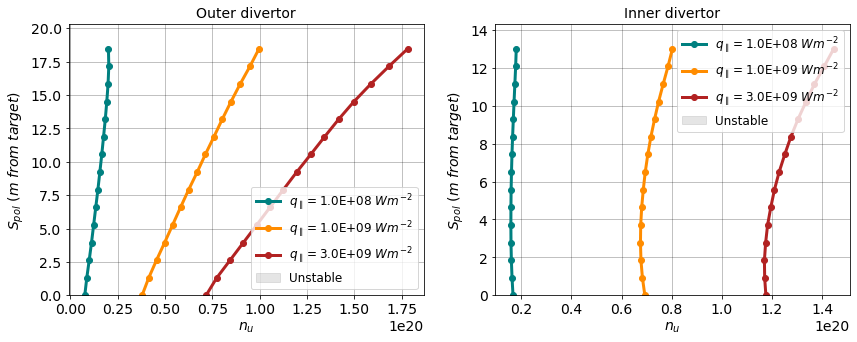

In [10]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)
cvar = "density"
fig, axes = plt.subplots(1,2, figsize = (14,5))
# fig.suptitle("Density scan of front profiles")
ax = axes[0]

basis = "cvar"

for k, side in enumerate(["ou", "iu"]):

    for i, q0 in enumerate(list_q):
        
        o = qscan[side][cvar][q0].copy()
        x = o[basis]        
        axes[k].plot(x, o["Splot"],  marker = "o", markersize = 6, linewidth = 3,  color = colors[i], label = r"$q_\parallel=$"+"{:.1E} ".format(q0)+"$Wm^{-2}$")


for ax in axes:
    
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    
    ylims = ax.get_ylim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$n_{u}$")
    # ax.set_xlabel("$n_{u}/n_{u0}$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    # ax.set_ylabel("$S_{\parallel}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    # ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

In [147]:
windows = dict()
thresholds = dict()

for side in ["iu", "ou"]:
    windows[side] = []
    thresholds[side] = []
    for i, q0 in enumerate(list_q):
        o = qscan[side][cvar][q0]
        windows[side].append(o["window_ratio"])
        thresholds[side].append(o["threshold"])

In [149]:
windows["ou"]

[2.6410256410256414, 2.6288659793814437, 2.4850136239782015]

## Plot profiles

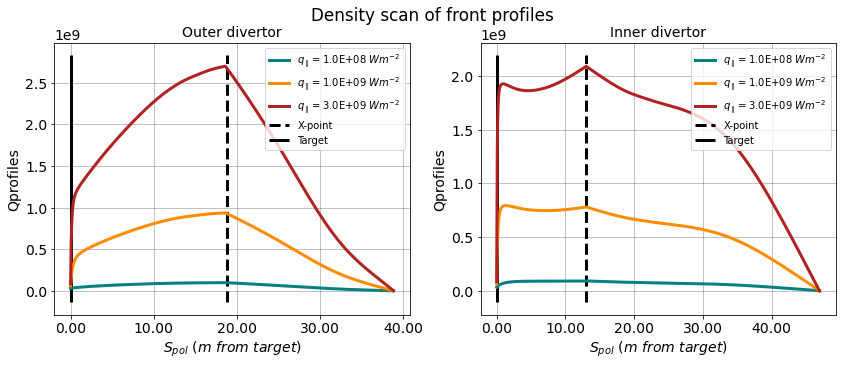

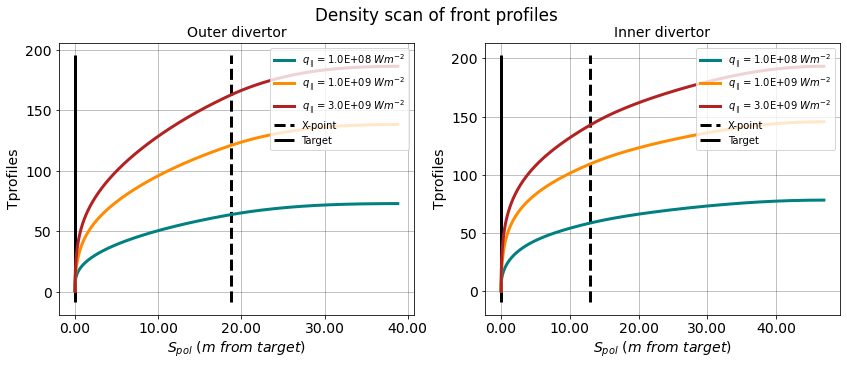

In [171]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)
for param in ["Qprofiles", "Tprofiles"]:

    fig, axes = plt.subplots(1,2, figsize = (14,5))
    fig.suptitle("Density scan of front profiles")
    ax = axes[0]

    basis = "crel"

    for k, side in enumerate(["ou", "iu"]):

        for i, q0 in enumerate(list_q):
            d = eqb[side][design]
            o = qscan[side][cvar][q0].copy()
            point = 0
            axes[k].plot(o["Sprofiles"][point], o[param][point], linewidth = 3,  color = colors[i], label = r"$q_\parallel=$"+"{:.1E} ".format(q0)+"$Wm^{-2}$")

        ylim = axes[k].get_ylim()
        axes[k].vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed")
        axes[k].vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid")
        axes[k].set_ylabel(param)

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend(fontsize = 10, loc = "upper right")
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
        # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")

## Find hot end of front

In [82]:
for k, side in enumerate(["ou", "iu"]):
    for i, q0 in enumerate(list_q):
        o = qscan[side][cvar][q0]
        num_profiles = len(o["Rprofiles"])
        index_c = [] # index of cold end

        for i, Rprofile in enumerate(o["Rprofiles"]):
            Rmax = np.nanmax(Rprofile)
            R1pc = 0.01 * Rmax
            index_c.append(np.argmin(np.abs(Rprofile-R1pc)))

        o["index_c"] = index_c


In [54]:
o["index_c"]

[65, 47, 39, 35, 32, 28, 24, 20, 18, 16, 18, 645, 0, 0, 0]

## Plot

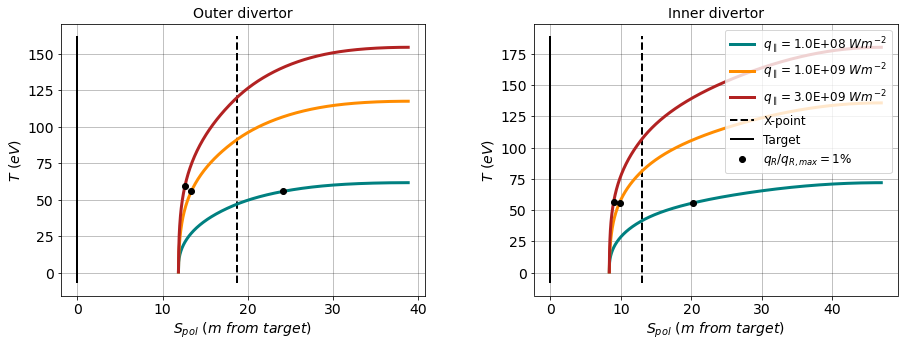

In [137]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)

fig, axes = plt.subplots(1,2, figsize = (15,5))
plt.subplots_adjust(hspace=0, wspace = 0.3)
ax = axes[0]

basis = "crel"

for k, side in enumerate(["ou", "iu"]):

    for i, q0 in enumerate(list_q):
        d = eqb[side][design]
        o = qscan[side][cvar][q0].copy()
        
        point = 9
        index_c = o["index_c"][point]
        axes[k].plot(o["Sprofiles"][point], o["Tprofiles"][point], linewidth = 3,  color = colors[i], label = r"$q_\parallel=$"+"{:.1E} ".format(q0)+"$Wm^{-2}$")
        axes[k].plot(o["Sprofiles"][point][index_c], o["Tprofiles"][point][index_c], linewidth = 0, color = "black", marker = "o")
        
    ylim = axes[k].get_ylim()
    axes[k].vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed", linewidth = 2)
    axes[k].vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid", linewidth = 2)

for ax in axes:
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel("$T\ (eV)$")
    
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
    
    
    
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

h,l = axes[1].get_legend_handles_labels()
extra_handles = [mpl.lines.Line2D([0], [0], color = "black", marker = "o", linewidth=0, label = "$q_{R}/q_{R,max}=1\%$")]
# axes[1].legend(fontsize = 10, handles = h+extra_handles, bbox_to_anchor=(1.05,1))
axes[1].legend(fontsize = 12, handles = h+extra_handles, loc = "upper right")

In [60]:
ax.get_legend_handles_labels()

([<matplotlib.lines.Line2D at 0x2c0c50cd2b0>,
 ['$q_\\parallel=$1.0E+08 $Wm^{-2}$',
  '$q_\\parallel=$5.0E+08 $Wm^{-2}$',
  '$q_\\parallel=$1.0E+09 $Wm^{-2}$',
  '$q_\\parallel=$2.0E+09 $Wm^{-2}$',
  'X-point',
  'Target'])

C:\Users\Mike\AppData\Local\Temp/ipykernel_10968/271567902.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2%}".format(i) for i in cb.get_ticks()])


Text(0, 0.5, 'Temperature (eV)')

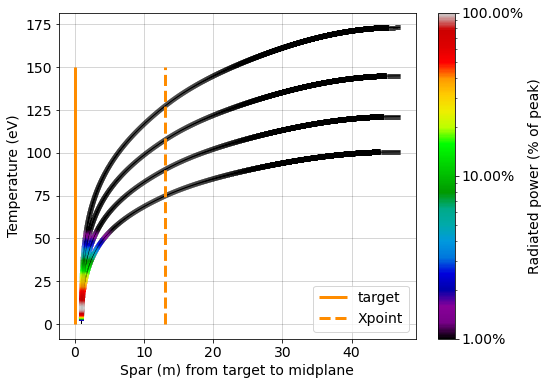

In [32]:
side = "iu"
list_q = [0.25e9, 0.50e9, 1.0e9, 2e9]
fig, ax = plt.subplots(figsize=(8,6))

d = eqb[side][design]

cmap = plt.get_cmap("plasma")
colors = make_colors(len(o["Tprofiles"]), cmap)   
point = 1

for i, q0 in enumerate(list_q):
    o = qscan[side][cvar][q0].copy()
    
    ax.plot(o["Sprofiles"][point], o["Tprofiles"][point], color = "black", linewidth = 1, zorder = 0)
    
    x = o["Sprofiles"][point]
    y = o["Tprofiles"][point]
    z = np.array(o["Rprofiles"][point])/np.nanmax(np.array(o["Rprofiles"][point]))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = mpl.colors.LogNorm(0.01, 1)
    lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
    lc.set_array(z)
    lc.set_linewidth(5)
    lc.set_zorder(10)
    line = ax.add_collection(lc)
    
ax.vlines(0, 0, 150, zorder = 50, label = "target", color = "darkorange", linewidth = 3)
ax.vlines(d["S"][d["Xpoint"]], 0, 150, zorder = 50, label = "Xpoint", color = "darkorange", linewidth = 3, linestyle = "dashed")
# ax.hlines(100,0,40,color ="red", zorder = 50)

# norm = mpl.colors.BoundaryNorm(np.linspace(global_min, global_max, 100), plt.get_cmap("gist_ncar").N)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("nipy_spectral")),  orientation="vertical", label = "Radiated power (% of peak)")
cb.ax.set_yticklabels(["{:.2%}".format(i) for i in cb.get_ticks()]) 

# ax.set_xlim(0,40)
ax.legend(loc="lower right")
ax.grid(color = "black", alpha = 0.2)
ax.set_xlabel("Spar (m) from target to midplane")
ax.set_ylabel("Temperature (eV)")
# ax.set_title("$q_{\parallel}=$"+"{:.2E}".format(q_choice)+"$Wm^{-2}$")

## Impact on  radiation profiles

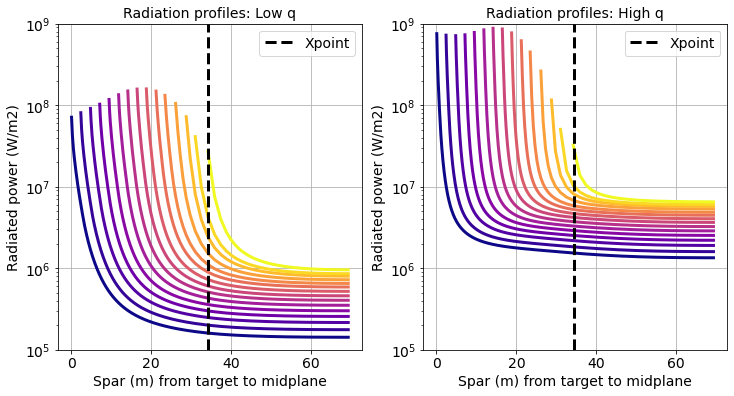

In [97]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

    # for i, q0 in enumerate(list_q):
    #     d = eqb[side][design]
    #     o = qscan[side][cvar][q0].copy()
colors = make_colors(len(o["Tprofiles"]), plt.get_cmap("plasma"))  

d = eqb[side][design]
ax = axes[0]
ax.set_title("Radiation profiles: Low q")
o = qscan["ou"]["density"][list_q[0]]


for i, _ in enumerate(o["Sprofiles"]):
    Rprofile = o["Rprofiles"][i]
    Rprofile[Rprofile==0] = np.nan
    ax.plot(o["Sprofiles"][i], Rprofile, color = colors[i])
    
ax = axes[1]
ax.set_title("Radiation profiles: High q")
o = qscan["ou"]["density"][list_q[-1]]
for i, _ in enumerate(o["Sprofiles"]):
    Rprofile = o["Rprofiles"][i]
    Rprofile[Rprofile==0] = np.nan
    ax.plot(o["Sprofiles"][i], o["Rprofiles"][i], color = colors[i])

for ax in axes:
    ax.vlines(d["S"][d["Xpoint"]], 1e5, 1e9, zorder = 5, label = "Xpoint", color = "black", linewidth = 3, linestyle = "dashed")    
    ax.legend()
    ax.set_ylim(1e5, 1e9)
    ax.set_yscale("log")
    ax.set_xlabel("Spar (m) from target to midplane")
    ax.set_ylabel("Radiated power (W/m2)")

# plt.xlim(0,3)

## Radiation and temp gradients

C:\Users\Mike\AppData\Local\Temp/ipykernel_9032/2117320981.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()])


Text(0.5, 1.0, 'Temperature profiles for scan of front locations')

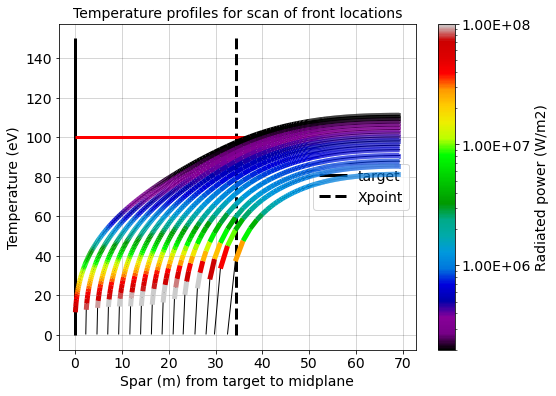

In [ ]:
side = "ou"

fig, ax = plt.subplots(figsize=(8,6))
o = qscan["ou"]["density"][list_q[0]]
d = eqb[side][design]

cmap = plt.get_cmap("plasma")
colors = make_colors(len(o["Tprofiles"]), cmap)   

for i, Tprofile in enumerate(o["Tprofiles"]):
    ax.plot(o["Sprofiles"][i], Tprofile, color = "black", linewidth = 1)
    
    x = o["Sprofiles"][i]
    y = Tprofile
    z = np.array(o["Rprofiles"][i])
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = mpl.colors.LogNorm(2e6, 1e9)
    lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
    lc.set_array(z)
    lc.set_linewidth(5)
    lc.set_zorder(10)
    line = ax.add_collection(lc)
    
ax.vlines(0, 0, 150, zorder = 5, label = "target", color = "black", linewidth = 3)
ax.vlines(d["S"][d["Xpoint"]], 0, 150, zorder = 5, label = "Xpoint", color = "black", linewidth = 3, linestyle = "dashed")
ax.hlines(100,0,40,color ="red", zorder = 5)

# norm = mpl.colors.BoundaryNorm(np.linspace(global_min, global_max, 100), plt.get_cmap("gist_ncar").N)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("nipy_spectral")),  orientation="vertical", label = "Radiated power (W/m2)")
cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()]) 

ax.legend(loc="center right")
ax.grid(color = "black", alpha = 0.2)
ax.set_xlabel("Spar (m) from target to midplane")
ax.set_ylabel("Temperature (eV)")
ax.set_title("Temperature profiles for scan of front locations")

In [140]:
qscan["ou"]["density"][list_q[0]]["Qprofiles"][5]

array([ 4.27315058e+07,  6.65399911e+07,  8.37793188e+07,  9.64738703e+07,
        1.06551845e+08,  1.14860998e+08,  1.21850879e+08,  1.27809866e+08,
        1.32946986e+08,  1.37422009e+08,  1.41358637e+08,  1.44852406e+08,
        1.47976926e+08,  1.50789384e+08,  1.53335387e+08,  1.55652995e+08,
        1.57769031e+08,  1.59723273e+08,  1.61546326e+08,  1.63258925e+08,
        1.64878053e+08,  1.66417746e+08,  1.67889717e+08,  1.69303833e+08,
        1.70668388e+08,  1.71990207e+08,  1.73275082e+08,  1.74527990e+08,
        1.75753240e+08,  1.76954578e+08,  1.78135357e+08,  1.79298691e+08,
        1.80447385e+08,  1.81583959e+08,  1.82710692e+08,  1.83829656e+08,
        1.84942658e+08,  1.86051259e+08,  1.87156882e+08,  1.88260831e+08,
        1.89364311e+08,  1.90468523e+08,  1.91575120e+08,  1.92685911e+08,
        1.93802656e+08,  1.94927074e+08,  1.96060826e+08,  1.97204701e+08,
        1.98358351e+08,  1.99521330e+08,  2.00693179e+08,  2.01873429e+08,
        2.03062475e+08,  

## Normalised radiation

C:\Users\Mike\AppData\Local\Temp/ipykernel_9032/3289446386.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2%}".format(i) for i in cb.get_ticks()])


Text(0.5, 1.0, '$q_{\\parallel}=$2.00E+09$Wm^{-2}$')

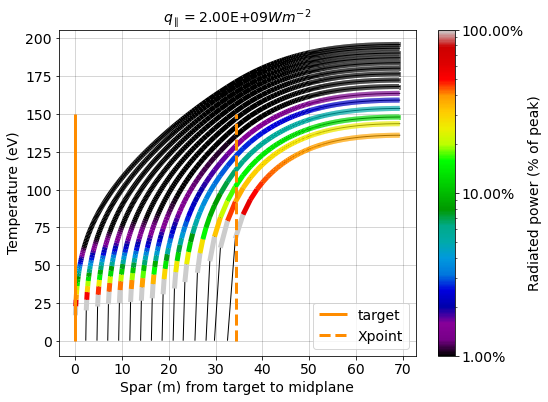

In [135]:
side = "ou"
list_q = [0.25e9, 0.50e9, 1.0e9, 2e9]
fig, ax = plt.subplots(figsize=(8,6))
q_choice = list_q[-1]
o = qscan[side]["density"][q_choice]
d = eqb[side][design]

cmap = plt.get_cmap("plasma")
colors = make_colors(len(o["Tprofiles"]), cmap)   

for i, Tprofile in enumerate(o["Tprofiles"]):
    ax.plot(o["Sprofiles"][i], Tprofile, color = "black", linewidth = 1)
    
    x = o["Sprofiles"][i]
    y = Tprofile
    z = np.array(o["Rprofiles"][i])/np.nanmax(np.array(o["Rprofiles"][i]))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = mpl.colors.LogNorm(0.01, 1)
    lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
    lc.set_array(z)
    lc.set_linewidth(5)
    lc.set_zorder(10)
    line = ax.add_collection(lc)
    
ax.vlines(0, 0, 150, zorder = 50, label = "target", color = "darkorange", linewidth = 3)
ax.vlines(d["S"][d["Xpoint"]], 0, 150, zorder = 50, label = "Xpoint", color = "darkorange", linewidth = 3, linestyle = "dashed")
# ax.hlines(100,0,40,color ="red", zorder = 50)

# norm = mpl.colors.BoundaryNorm(np.linspace(global_min, global_max, 100), plt.get_cmap("gist_ncar").N)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("nipy_spectral")),  orientation="vertical", label = "Radiated power (% of peak)")
cb.ax.set_yticklabels(["{:.2%}".format(i) for i in cb.get_ticks()]) 

# ax.set_xlim(0,40)
ax.legend(loc="lower right")
ax.grid(color = "black", alpha = 0.2)
ax.set_xlabel("Spar (m) from target to midplane")
ax.set_ylabel("Temperature (eV)")
ax.set_title("$q_{\parallel}=$"+"{:.2E}".format(q_choice)+"$Wm^{-2}$")

# Density

In [165]:
design = "V10"
list_nu0 = [1.0e20, 2.0e20, 5e20]
list_cvars = ["impurity_frac"]
nscan = dict()

for side in ["iu","ou"]:
    nscan[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        nscan[side][cvar] = dict()
        print(f"{cvar}")
        
        for nu0 in list_n:
            print("nu0 value {}...".format(nu0))

            d = eqb20k[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint

            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            constants["nu0"] = nu0

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)

            nscan[side][cvar][nu0] = out

Side iu...
impurity_frac
nu0 value 1e+20...
Solving...0...7393...8342...8843...9163...9383...9543...9661...9749...9814...9863...9902...9935...9967...9999...Complete in 35.3 seconds
nu0 value 2e+20...
Solving...0...7393...8342...8843...9163...9383...9543...9661...9749...9814...9863...9902...9935...9967...9999...Complete in 42.6 seconds
nu0 value 5e+20...
Solving...0...7393...8342...8843...9163...9383...9543...9661...9749...9814...9863...9902...9935...9967...9999...Complete in 37.7 seconds
Side ou...
impurity_frac
nu0 value 1e+20...
Solving...0...7910...8610...9002...9278...9488...9645...9758...9838...9893...9932...9958...9977...9990...9999...Complete in 34.2 seconds
nu0 value 2e+20...
Solving...0...7910...8610...9002...9278...9488...9645...9758...9838...9893...9932...9958...9977...9990...9999...Complete in 35.0 seconds
nu0 value 5e+20...
Solving...0...7910...8610...9002...9278...9488...9645...9758...9838...9893...9932...9958...9977...9990...9999...Complete in 35.8 seconds


## Find hot end of front

In [173]:
cvar = "impurity_frac"

for k, side in enumerate(["ou", "iu"]):
    for i, nu0 in enumerate(list_nu0):
        o = nscan[side][cvar][nu0]
        num_profiles = len(o["Rprofiles"])
        index_c = [] # index of cold end

        for i, Rprofile in enumerate(o["Rprofiles"]):
            Rmax = np.nanmax(Rprofile)
            R1pc = 0.01 * Rmax
            index_c.append(np.argmin(np.abs(Rprofile-R1pc)))

        o["index_c"] = index_c


In [54]:
o["index_c"]

[65, 47, 39, 35, 32, 28, 24, 20, 18, 16, 18, 645, 0, 0, 0]

## Plot

Text(0.5, 1.0, 'Inner divertor')

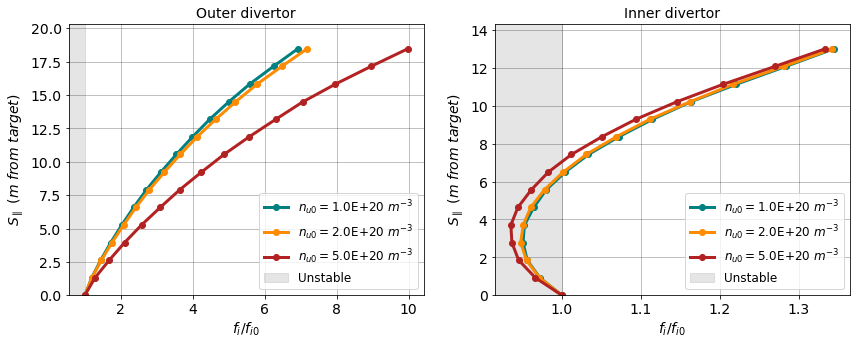

In [187]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)
cvar = "impurity_frac"
fig, axes = plt.subplots(1,2, figsize = (14,5))
# fig.suptitle("Density scan of front profiles")
ax = axes[0]

basis = "crel"

for k, side in enumerate(["ou", "iu"]):

    for i, nu0 in enumerate(list_nu0):
        
        o = nscan[side][cvar][nu0].copy()
        x = o[basis]        
        axes[k].plot(x, o["Splot"],  marker = "o", markersize = 6, linewidth = 3,  color = colors[i], label = r"$n_{u0}=$"+"{:.1E} ".format(nu0)+"$m^{-3}$")


for ax in axes:
    
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    
    ylims = ax.get_ylim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$f_{i}/f_{i0}$")
    # ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel("$S_{\parallel}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    # ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

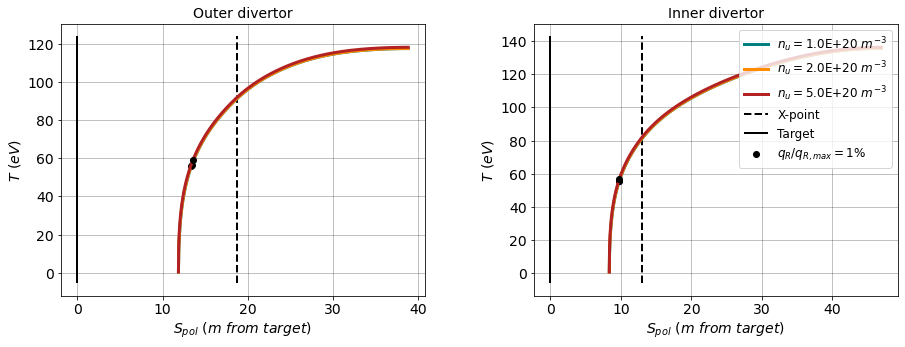

In [181]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)

fig, axes = plt.subplots(1,2, figsize = (15,5))
plt.subplots_adjust(hspace=0, wspace = 0.3)
ax = axes[0]

basis = "cvar"

for k, side in enumerate(["ou", "iu"]):

    for i, nu0 in enumerate(list_nu0):
        d = eqb[side][design]
        o = nscan[side][cvar][nu0].copy()
        
        point = 9
        index_c = o["index_c"][point]
        axes[k].plot(o["Sprofiles"][point], o["Tprofiles"][point], linewidth = 3,  color = colors[i], label = r"$n_u=$"+"{:.1E} ".format(nu0)+"$m^{-3}$")
        axes[k].plot(o["Sprofiles"][point][index_c], o["Tprofiles"][point][index_c], linewidth = 0, color = "black", marker = "o")
        
    ylim = axes[k].get_ylim()
    axes[k].vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed", linewidth = 2)
    axes[k].vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid", linewidth = 2)

for ax in axes:
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel("$T\ (eV)$")
    
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
    
    
    
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

h,l = axes[1].get_legend_handles_labels()
extra_handles = [mpl.lines.Line2D([0], [0], color = "black", marker = "o", linewidth=0, label = "$q_{R}/q_{R,max}=1\%$")]
# axes[1].legend(fontsize = 10, handles = h+extra_handles, bbox_to_anchor=(1.05,1))
axes[1].legend(fontsize = 12, handles = h+extra_handles, loc = "upper right")

In [176]:
for i, nu0 in enumerate(list_nu0):
    o = nscan[side][cvar][nu0]
    print(o["constants"]["nu0"])

1e+20
2e+20
5e+20


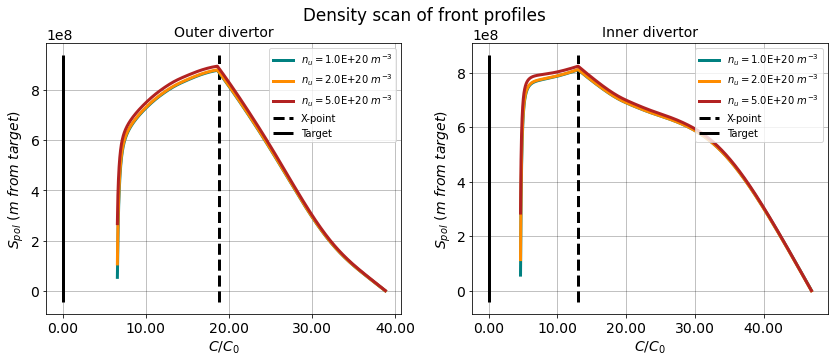

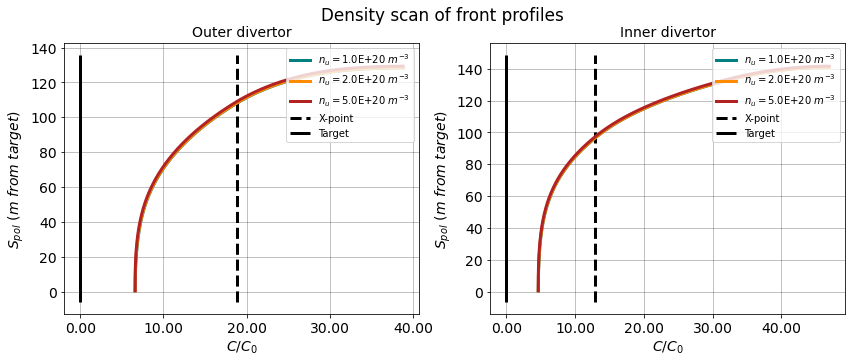

In [182]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)
for param in ["Qprofiles", "Tprofiles"]:

    fig, axes = plt.subplots(1,2, figsize = (14,5))
    fig.suptitle("Density scan of front profiles")
    ax = axes[0]

    basis = "crel"

    for k, side in enumerate(["ou", "iu"]):

        for i, ne in enumerate(list_n):
            d = eqb[side][design]
            o = nscan[side][cvar][ne].copy()
            point = 5
            axes[k].plot(o["Sprofiles"][point], o[param][point], linewidth = 3,  color = colors[i], label = r"$n_u=$"+"{:.1E} ".format(ne)+"$m^{-3}$")

        ylim = axes[k].get_ylim()
        axes[k].vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed")
        axes[k].vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid")

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel("$C/C_{0}$")
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend(fontsize = 10, loc = "upper right")
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
        # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")

# Q scan log grid

In [194]:
design = "SPR38"
list_q = [0.25e9, 0.50e9, 1.0e9, 2e9]
list_cvars = ["density"]
qscanlog = dict()

for side in ["iu","ou"]:
    qscanlog[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        qscanlog[side][cvar] = dict()
        print(f"{cvar}")
        
        for q0 in list_q:
            print("q value {}...".format(q0))

            d = eqblog[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05
            constants["gamma_sheath"] = 1

            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            constants["qpllu0"] = q0

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)

            qscanlog[side][cvar][q0] = out

Side iu...
density
q value 250000000.0...
Solving...0...373...419...443...458...469...477...483...487...490...493...495...496...498...499...Complete in 21.7 seconds
q value 500000000.0...
Solving...0...373...419...443...458...469...477...483...487...490...493...495...496...498...499...Complete in 24.9 seconds
q value 1000000000.0...
Solving...0...373...419...443...458...469...477...483...487...490...493...495...496...498...499...Complete in 23.2 seconds
q value 2000000000.0...
Solving...0...373...419...443...458...469...477...483...487...490...493...495...496...498...499...Complete in 23.2 seconds
Side ou...
density
q value 250000000.0...
Solving...0...388...422...440...453...464...473...480...486...490...493...496...497...498...499...Complete in 21.8 seconds
q value 500000000.0...
Solving...0...388...422...440...453...464...473...480...486...490...493...496...497...498...499...Complete in 20.2 seconds
q value 1000000000.0...
Solving...0...388...422...440...453...464...473...480...486.

Text(0.5, 1.0, 'Inner divertor')

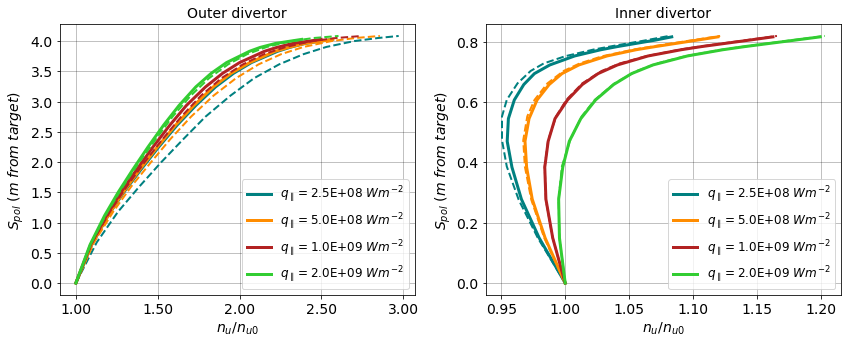

In [202]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)

fig, axes = plt.subplots(1,2, figsize = (14,5))
# fig.suptitle("Density scan of front profiles")
ax = axes[0]

basis = "crel"

for k, side in enumerate(["ou", "iu"]):
    for i, q0 in enumerate(list_q):
        
        o = qscanlog[side][cvar][q0].copy()
        x = o[basis]        
        axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 0, linewidth = 3,  color = colors[i], label = r"$q_\parallel=$"+"{:.1E} ".format(q0)+"$Wm^{-2}$")
        
        o = qscan[side][cvar][q0].copy()
        x = o[basis]
        axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 0, linewidth = 2,  color = colors[i], linestyle = "dashed", )


for ax in axes:
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$n_{u}/n_{u0}$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

In [10]:
side = "ou"
list_q = [0.25e9, 0.50e9, 1.0e9, 2e9]

# q_choice = list_q[-1]
# o = qscan[side]["density"][q_choice]
# d = eqb[side][design]

def plot_norm_rad(o, d):
    fig, ax = plt.subplots(figsize=(8,6))

    cmap = plt.get_cmap("plasma")
    colors = make_colors(len(o["Tprofiles"]), cmap)   

    for i, Tprofile in enumerate(o["Tprofiles"]):
        ax.plot(o["Sprofiles"][i], Tprofile, color = "black", linewidth = 1)

        x = o["Sprofiles"][i]
        y = Tprofile
        z = np.array(o["Rprofiles"][i])/np.nanmax(np.array(o["Rprofiles"][i]))
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        norm = mpl.colors.LogNorm(0.01, 1)
        lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
        lc.set_array(z)
        lc.set_linewidth(5)
        lc.set_zorder(10)
        line = ax.add_collection(lc)

    ax.vlines(0, 0, 150, zorder = 50, label = "target", color = "darkorange", linewidth = 3)
    ax.vlines(d["S"][d["Xpoint"]], 0, 150, zorder = 50, label = "Xpoint", color = "darkorange", linewidth = 3, linestyle = "dashed")
    # ax.hlines(100,0,40,color ="red", zorder = 50)

    # norm = mpl.colors.BoundaryNorm(np.linspace(global_min, global_max, 100), plt.get_cmap("gist_ncar").N)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("nipy_spectral")),  orientation="vertical", label = "Radiated power (% of peak)")
    cb.ax.set_yticklabels(["{:.2%}".format(i) for i in cb.get_ticks()]) 

    # ax.set_xlim(0,40)
    ax.legend(loc="lower right")
    ax.grid(color = "black", alpha = 0.2)
    ax.set_xlabel("Spar (m) from target to midplane")
    ax.set_ylabel("Temperature (eV)")
    ax.set_title("$q_{\parallel}=$"+"{:.2E}".format(q_choice)+"$Wm^{-2}$")
    
def plot_rad(o,d):
    fig, ax = plt.subplots(figsize=(8,6))
    cmap = plt.get_cmap("plasma")
    colors = make_colors(len(o["Tprofiles"]), cmap)   

    for i, Tprofile in enumerate(o["Tprofiles"]):
        ax.plot(o["Sprofiles"][i], Tprofile, color = "black", linewidth = 1)

        x = o["Sprofiles"][i]
        y = Tprofile
        z = np.array(o["Rprofiles"][i])
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        norm = mpl.colors.LogNorm(2e6, 1.5e9)
        lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
        lc.set_array(z)
        lc.set_linewidth(5)
        lc.set_zorder(10)
        line = ax.add_collection(lc)

    ax.vlines(0, 0, 150, zorder = 50, label = "target", color = "darkorange", linewidth = 3)
    ax.vlines(d["S"][d["Xpoint"]], 0, 150, zorder = 50, label = "Xpoint", color = "darkorange", linewidth = 3, linestyle = "dashed")
    # ax.hlines(100,0,40,color ="red", zorder = 5)

    # norm = mpl.colors.BoundaryNorm(np.linspace(global_min, global_max, 100), plt.get_cmap("gist_ncar").N)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("nipy_spectral")),  orientation="vertical", label = "Radiated power (W/m3)")
    cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()]) 

    ax.legend(loc="center right")
    ax.grid(color = "black", alpha = 0.2)
    ax.set_xlabel("Spar (m) from target to midplane")
    ax.set_ylabel("Temperature (eV)")
    ax.set_title("Temperature profiles for scan of front locations")
    # o = qscan[side]["density"][q_choice]
    # d = eqb[side][design]
    # plot_norm_rad(o, d)

# Q scan: Low target q
- There is a huge jump in radiation between the first and second cells
- This sharp temp gradient means that the radiation has to access a wider temperature range to radiate all the heat
- This is why the front widens when it's closer to the Xpoint
- Two ways to attack this. First one is reduce the target temp and sheath gamma. This will reduce the amount of heat flux that the boundary condition of the target is taking out of the system, and hopefully reduce the temperature gradient near the first cell
- Second: exponential cell resolution towards the target

In [171]:
design = "SPR38"
list_Tt = [0.5, 0.1]
list_cvars = ["density"]
Ttscan = dict()

for side in ["iu","ou"]:
    Ttscan[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        Ttscan[side][cvar] = dict()
        print(f"{cvar}")
        
        for Tt in list_Tt:
            print("Tt value {}...".format(Tt))

            d = eqb[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05
            constants["Tt"] = Tt
            constants["gamma_sheath"] = 1
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            # constants["qpllu0"] = q0

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)

            Ttscan[side][cvar][Tt] = out

Side iu...
density
Tt value 0.5...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 22.3 seconds
Tt value 0.1...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...

C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


100...102...104...Complete in 23.8 seconds
Side ou...
density
Tt value 0.5...
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 18.8 seconds
Tt value 0.1...
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 21.2 seconds


C:\Users\Mike\AppData\Local\Temp/ipykernel_9032/1906178877.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()])


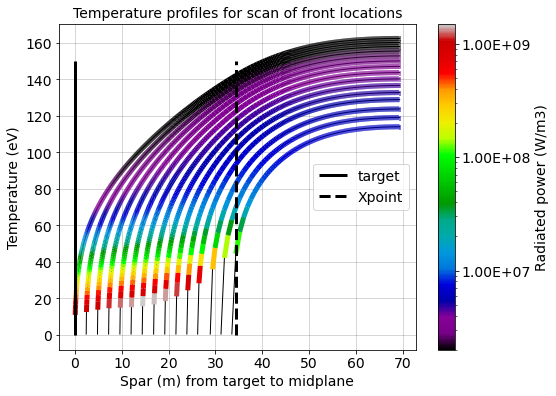

In [172]:
# o = qscan[side]["density"][0.5]
# d = eqb[side][design]
# plot_norm_rad(o, d)

o = qscan[side]["density"][0.5]
d = eqb[side][design]
plot_rad(o, d)

# Scan in Tt with and without log grid

In [70]:
design = "SPR38"
list_cvars = ["density"]
store_cases = [{"Tt":0.25},
               {"Tt":0.5},
               {"Tt":1.0},
               {"Tt":1.5}]

store = dict()
for side in ["iu","ou"]:
    store[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        store[side][cvar] = [0]*len(store_cases)
        print(f"{cvar}")
        
        for i in range(len(store_cases)):
            print("Case", store_cases[i])

            d = eqb[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05
            constants["Tt"] = store_cases[i]["Tt"]
            # constants["gamma_sheath"] = store_cases[i]["gamma_sheath"]
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)
            store[side][cvar][i] = out
            
scan_Tt = copy.deepcopy(store)

Side iu...
density
Case {'Tt': 0.25}
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 21.5 seconds
Case {'Tt': 0.5}
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 21.4 seconds
Case {'Tt': 1.0}
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 20.6 seconds
Case {'Tt': 1.5}
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 18.3 seconds
Side ou...
density
Case {'Tt': 0.25}
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 19.6 seconds
Case {'Tt': 0.5}
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 19.9 seconds
Case {'Tt': 1.0}
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 20.5 seconds
Case {'Tt': 1.5}
Solving...0..

## 100k uniform

In [89]:
design = "SPR38"
list_cvars = ["density"]
store_cases = [{"Tt":0.25},
               {"Tt":0.5},
               {"Tt":1.0},
               {"Tt":1.5}]

store = dict()
for side in ["iu","ou"]:
    store[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        store[side][cvar] = [0]*len(store_cases)
        print(f"{cvar}")
        
        for i in range(len(store_cases)):
            print("Case", store_cases[i])

            d = eqb100k[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05
            constants["Tt"] = store_cases[i]["Tt"]
            # constants["gamma_sheath"] = store_cases[i]["gamma_sheath"]
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)
            store[side][cvar][i] = out
            
scan_Tt100k = copy.deepcopy(store)

Side iu...
density
Case {'Tt': 0.25}
Solving...0...37661...42167...44554...46078...47133...47895...48457...48862...49149...49360...49529...49681...49834...49999...Complete in 101.3 seconds
Case {'Tt': 0.5}
Solving...0...37661...42167...44554...46078...47133...47895...48457...48862...49149...49360...49529...49681...49834...49999...Complete in 94.4 seconds
Case {'Tt': 1.0}
Solving...0...37661...42167...44554...46078...47133...47895...48457...48862...49149...49360...49529...49681...49834...49999...Complete in 82.5 seconds
Case {'Tt': 1.5}
Solving...0...37661...42167...44554...46078...47133...47895...48457...48862...49149...49360...49529...49681...49834...49999...Complete in 82.8 seconds
Side ou...
density
Case {'Tt': 0.25}
Solving...0...39249...42578...44421...45742...46805...47681...48380...48910...49295...49565...49750...49873...49948...49999...Complete in 81.1 seconds
Case {'Tt': 0.5}
Solving...0...39249...42578...44421...45742...46805...47681...48380...48910...49295...49565...49750...

## 100k log

In [52]:
design = "SPR38"
list_cvars = ["density"]
store_cases = [{"Tt":0.25},
               {"Tt":0.5},
               {"Tt":1.0},
               {"Tt":1.5}]

store = dict()
for side in ["iu","ou"]:
    store[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        store[side][cvar] = [0]*len(store_cases)
        print(f"{cvar}")
        
        for i in range(len(store_cases)):
            print("Case", store_cases[i])

            d = eqblog[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05
            constants["Tt"] = store_cases[i]["Tt"]
            # constants["gamma_sheath"] = store_cases[i]["gamma_sheath"]
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)
            store[side][cvar][i] = out
            
scan_Ttlog = copy.deepcopy(store)

Side iu...
density
Case {'Tt': 0.25}
Solving...0...37661...42167...44554...46078...47133...47895...48457...48862...49149...49360...49529...49681...49834...49999...Complete in 81.0 seconds
Case {'Tt': 0.5}
Solving...0...37661...42167...44554...46078...47133...47895...48457...48862...49149...49360...49529...49681...49834...49999...Complete in 79.9 seconds
Case {'Tt': 1.0}
Solving...0...37661...42167...44554...46078...47133...47895...48457...48862...49149...49360...49529...49681...49834...49999...Complete in 81.1 seconds
Case {'Tt': 1.5}
Solving...0...37661...42167...44554...46078...47133...47895...48457...48862...49149...49360...49529...49681...49834...49999...Complete in 77.4 seconds
Side ou...
density
Case {'Tt': 0.25}
Solving...0...39249...42578...44421...45742...46805...47681...48380...48910...49295...49565...49750...49873...49948...49999...Complete in 80.9 seconds
Case {'Tt': 0.5}
Solving...0...39249...42578...44421...45742...46805...47681...48380...48910...49295...49565...49750...4

## 1k log

In [88]:
design = "SPR38"
list_cvars = ["density"]
store_cases = [{"Tt":0.25},
               {"Tt":0.5},
               {"Tt":1.0},
               {"Tt":1.5}]

store = dict()
for side in ["iu","ou"]:
    store[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        store[side][cvar] = [0]*len(store_cases)
        print(f"{cvar}")
        
        for i in range(len(store_cases)):
            print("Case", store_cases[i])

            d = eqblog1k[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05
            constants["Tt"] = store_cases[i]["Tt"]
            # constants["gamma_sheath"] = store_cases[i]["gamma_sheath"]
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)
            store[side][cvar][i] = out
            
scan_Ttlog1k = copy.deepcopy(store)

Side iu...
density
Case {'Tt': 0.25}
Solving...0...373...419...443...458...469...477...483...487...490...493...495...496...498...499...Complete in 22.3 seconds
Case {'Tt': 0.5}
Solving...0...373...419...443...458...469...477...483...487...490...493...495...496...498...499...Complete in 21.3 seconds
Case {'Tt': 1.0}
Solving...0...373...419...443...458...469...477...483...487...490...493...495...496...498...499...Complete in 19.5 seconds
Case {'Tt': 1.5}
Solving...0...373...419...443...458...469...477...483...487...490...493...495...496...498...499...Complete in 18.4 seconds
Side ou...
density
Case {'Tt': 0.25}
Solving...0...388...422...440...453...464...473...480...486...490...493...496...497...498...499...Complete in 18.8 seconds
Case {'Tt': 0.5}
Solving...0...388...422...440...453...464...473...480...486...490...493...496...497...498...499...Complete in 17.6 seconds
Case {'Tt': 1.0}
Solving...0...388...422...440...453...464...473...480...486...490...493...496...497...498...499...Compl

Base


C:\Users\Mike\AppData\Local\Temp/ipykernel_23092/2239709903.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()])
C:\Users\Mike\AppData\Local\Temp/ipykernel_23092/2239709903.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()])


log 1k
log 100k


C:\Users\Mike\AppData\Local\Temp/ipykernel_23092/2239709903.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()])


uniform 100k


C:\Users\Mike\AppData\Local\Temp/ipykernel_23092/2239709903.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()])


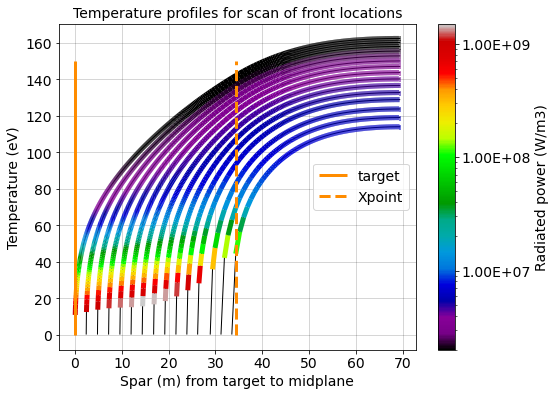

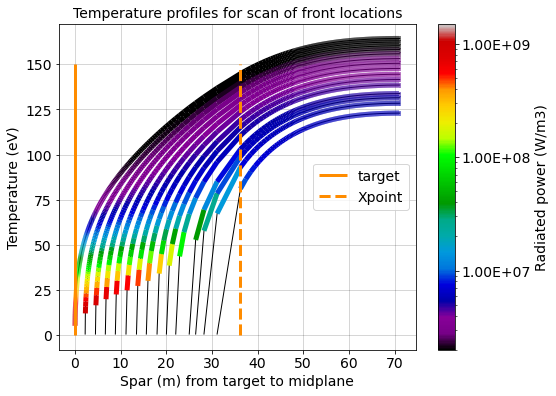

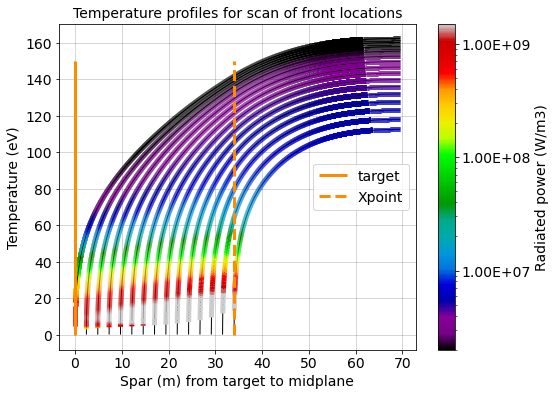

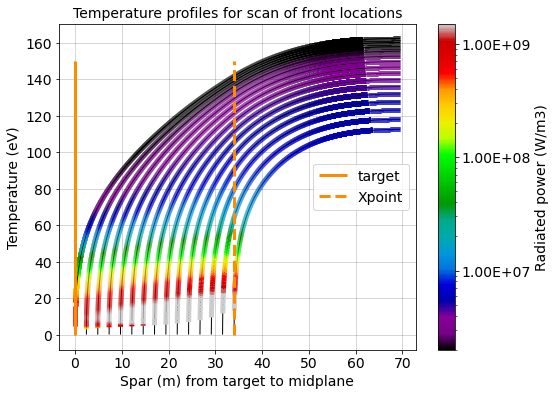

In [90]:
side = "ou"
case = 1
print("Base")
o = scan_Tt[side]["density"][case]
d = eqb[side][design]
plot_rad(o, d)

print("log 1k")
o = scan_Ttlog1k[side]["density"][case]
d = eqblog1k[side][design]
plot_rad(o, d)

print("log 100k")
o = scan_Ttlog[side]["density"][case]
d = eqblog[side][design]
plot_rad(o, d)

print("uniform 100k")
o = scan_Tt100k[side]["density"][case]
d = eqb100k[side][design]
plot_rad(o, d)


In [86]:
# [print("{:.3E}".format(x)) for x in o["Rprofiles"][0][:5]]  #print(o["Rprofiles"][0:5])

for study in [scan_Tt, scan_Ttlog1k, scan_Ttlog]:
    o = study[side]["density"][case]
    print(">>> FIRST FIVE CELLS OF RADIATION, q AND TEMPERATURE")
    for i in range(5):
        R = o["Rprofiles"][-1][i]
        T = o["Tprofiles"][-1][i]
        Q = o["Qprofiles"][-1][i]
        print(f"R: {R:.2E} || q: {Q:.2E} || T: {T:.2f}eV")
    print("")

>>> FIRST FIVE CELLS OF RADIATION, q AND TEMPERATURE
R: 0.00E+00 || q: 4.44E+07 || T: 0.50eV
R: 1.14E+08 || q: 6.46E+08 || T: 44.51eV
R: 3.29E+07 || q: 6.67E+08 || T: 56.64eV
R: 1.91E+07 || q: 6.61E+08 || T: 64.40eV
R: 1.43E+07 || q: 6.49E+08 || T: 70.11eV

>>> FIRST FIVE CELLS OF RADIATION, q AND TEMPERATURE
R: 0.00E+00 || q: 4.82E+07 || T: 0.50eV
R: 9.59E+06 || q: 7.34E+08 || T: 81.08eV
R: 8.56E+06 || q: 7.10E+08 || T: 86.42eV
R: 7.98E+06 || q: 6.86E+08 || T: 90.56eV
R: 7.63E+06 || q: 6.64E+08 || T: 93.79eV

>>> FIRST FIVE CELLS OF RADIATION, q AND TEMPERATURE
R: 0.00E+00 || q: 4.38E+07 || T: 0.50eV
R: 3.00E+09 || q: 1.91E+08 || T: 13.16eV
R: 2.68E+09 || q: 2.22E+08 || T: 14.57eV
R: 2.40E+09 || q: 2.49E+08 || T: 15.85eV
R: 2.16E+09 || q: 2.74E+08 || T: 17.01eV



# Log grid

In [193]:
design = "SPR38"
list_Tt = [0.5, 0.1]
list_cvars = ["density"]
store_cases = [{"Tt":0.05, "gamma_sheath":6},
               {"Tt":0.05, "gamma_sheath":1},
               {"Tt":0.05, "gamma_sheath":0.1},
               {"Tt":0.02, "gamma_sheath":0.1}]
    
scan_log = dict()

for side in ["iu","ou"]:
    scan_log[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        scan_log[side][cvar] = dict()
        print(f"{cvar}")
        
        for i in range(len(store_cases)):
            print("Case", store_cases[i])

            d = eqblog[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.05
            constants["Tt"] = store_cases[i]["Tt"]
            constants["gamma_sheath"] = store_cases[i]["gamma_sheath"]
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1]*0.95, 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 2,
                                                control_variable = cvar)

            Ttscan_log[side][cvar][Tt] = out

Side iu...
density
Case {'Tt': 0.05, 'gamma_sheath': 6}
Solving...0...
---SOLVING FOR INDEX 0

cvar: 1.000E+20, error1: 2.070E+00
cvar: 5.000E+19, error1: -1.990E-01
>Bounds: 5.000E+19-7.500E+19, cvar: 7.500E+19, error1: 8.655E-01
>Bounds: 5.000E+19-6.250E+19, cvar: 6.250E+19, error1: 3.141E-01
>Bounds: 5.000E+19-5.625E+19, cvar: 5.625E+19, error1: 5.262E-02
>Bounds: 5.312E+19-5.625E+19, cvar: 5.312E+19, error1: -7.444E-02
>Bounds: 5.469E+19-5.625E+19, cvar: 5.469E+19, error1: -1.122E-02
>Bounds: 5.469E+19-5.547E+19, cvar: 5.547E+19, error1: 2.062E-02
>Bounds: 5.469E+19-5.508E+19, cvar: 5.508E+19, error1: 4.678E-03
>Bounds: 5.488E+19-5.508E+19, cvar: 5.488E+19, error1: -3.278E-03
>Bounds: 5.488E+19-5.498E+19, cvar: 5.498E+19, error1: 6.991E-04
-----------error0: 0.000E+00, Tu: 162.44, Tucalc: 162.44
370...
---SOLVING FOR INDEX 370

cvar: 1.000E+20, error1: 2.089E+00
cvar: 5.000E+19, error1: -1.785E-01
>Bounds: 5.000E+19-7.500E+19, cvar: 7.500E+19, error1: 8.874E-01
>Bounds: 5.000E+19-6

KeyboardInterrupt: 

C:\Users\Mike\AppData\Local\Temp/ipykernel_9032/1906178877.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{:.2E}".format(i) for i in cb.get_ticks()])


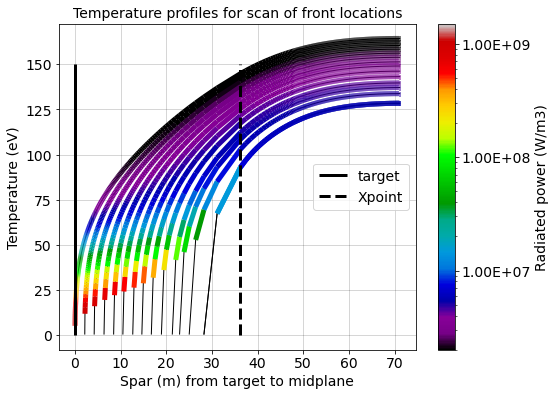

In [183]:
o = Ttscan_log[side]["density"][0.5]
d = eqblog[side][design]
plot_rad(o, d)

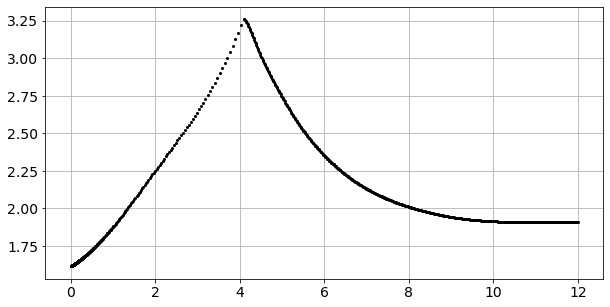

In [190]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(d["Spol"],d["Btot"], marker = "o", linewidth = 0, markersize = 2, color = "black")

In [184]:
o["Tprofiles"][0]

array([  0.5       ,   5.10234474,   5.12695041,   5.15168219,
         5.17654093,   5.20152745,   5.22664265,   5.25188737,
         5.27726249,   5.30276891,   5.32840751,   5.35417922,
         5.38008496,   5.40612566,   5.43230227,   5.45861575,
         5.48506707,   5.51165722,   5.53838722,   5.56525806,
         5.59227077,   5.61942639,   5.64672597,   5.67417059,
         5.70176133,   5.72949928,   5.75738558,   5.78542134,
         5.81360772,   5.84194587,   5.87043698,   5.89908224,
         5.92788287,   5.9568401 ,   5.98595519,   6.01522938,
         6.04466398,   6.07426029,   6.10401963,   6.13394334,
         6.16403279,   6.19428936,   6.22471445,   6.2553095 ,
         6.28607594,   6.31701525,   6.34812892,   6.37941845,
         6.41088539,   6.44253129,   6.47435774,   6.50636634,
         6.53855872,   6.57093654,   6.60350149,   6.63625525,
         6.66919957,   6.70233621,   6.73566694,   6.76919359,
         6.80291799,   6.83684201,   6.87096755,   6.90

# Imp scan

In [82]:
design = "SPR38"
list_fz = [0.02, 0.05, 0.07, 0.1]
list_cvars = ["density"]
fzscan = dict()

for side in ["iu","ou"]:
    fzscan[side] = dict()
    print("Side {}...".format(side))
    
    for cvar in list_cvars:
        fzscan[side][cvar] = dict()
        print(f"{cvar}")
        
        for fz in list_fz:
            print("fz value {}...".format(fz))

            d = eqb[side][design].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()

            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = fz

            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]

            constants["Lfunc"] = LfuncKallenbachAr     
            out = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar)

            fzscan[side][cvar][fz] = out

Side iu...
density
fz value 0.02...
Solving...0...19...35...49...60...70...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


77...84...

C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


89...92...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:147: RuntimeWarning: overflow encountered in multiply
  out["q"] = result[:,0]*B(s)


95...98...100...102...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:147: RuntimeWarning: invalid value encountered in multiply
  out["q"] = result[:,0]*B(s)


104...Complete in 23.6 seconds
fz value 0.05...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 22.3 seconds
fz value 0.07...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 25.0 seconds
fz value 0.1...
Solving...0...19...35...49...60...70...77...84...89...92...95...98...100...102...104...Complete in 24.8 seconds
Side ou...
density
fz value 0.02...
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 21.5 seconds
fz value 0.05...
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 23.9 seconds
fz value 0.07...
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 22.7 seconds
fz value 0.1...
Solving...0...56...98...133...166...198...229...258...282...301...315...325...333...337...340...Complete in 22.5 seconds


In [ ]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)

fig, axes = plt.subplots(1,2, figsize = (14,5))
# fig.suptitle("Density scan of front profiles")
ax = axes[0]

basis = "crel"

for k, side in enumerate(["ou", "iu"]):

    for i, q0 in enumerate(list_q):
        
        o = qscan[side][cvar][q0].copy()
        x = o[basis]        
        axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 6, linewidth = 3,  color = colors[i], label = r"$q_\parallel=$"+"{:.1E} ".format(q0)+"$Wm^{-2}$")


for ax in axes:
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$n_{u}/n_{u0}$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")